# All States
This workbook displays a basic 2x2 set of charts for every US state and territory. Data is sourced from the [COVID Tracking Project](https://covidtracking.com). Not all states provide hospitalization, recovery, or testing data. Sometimes the data has big holes. The COVID Tracking Project data does not include the over 5000 deaths in NY State that are *presumed* to have been COVID-19 related but where tests weren't performed.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
import scipy.optimize as opt
from datetime import datetime, timedelta
from data_mappings import state_full_names

In [20]:
states = pd.read_csv("https://covidtracking.com/api/states/daily.csv")
states['date'] = pd.to_datetime(states['date'],format='%Y%m%d')
states['state'] = states['state'].map(state_full_names)
states.rename(columns={
    'death': 'deaths',
    'deathIncrease': 'new_deaths',
    'positive': 'cases',
    'positiveIncrease': 'new_cases',
    'hospitalizedIncrease': 'new_hospitalizations',
    'onVentilatorCurrently': 'on_ventilator',
    'inIcuCurrently': 'in_icu'
},inplace=True)
states = states.sort_values(by=['state','date'])

In [21]:
los = sorted(states.state.unique())
for state in los:
    tmp = states[states.state == state]
    states.loc[tmp.index,'nc7d'] = states.loc[tmp.index,'new_cases'].rolling(window=7).mean()
    states.loc[tmp.index,'nd7d'] = states.loc[tmp.index,'new_deaths'].rolling(window=7).mean()
    states.loc[tmp.index,'ntri7d'] = states.loc[tmp.index,'totalTestResultsIncrease'].rolling(window=7).mean()
    states.loc[tmp.index,'new_recovered'] = states.loc[tmp.index,'recovered'] - states.loc[tmp.index,'recovered'].shift(1)
    states.loc[tmp.index,'rec7d'] = states.loc[tmp.index,'new_recovered'].rolling(window=7).mean()
states.replace(np.nan,0,inplace=True)
states.tail()

,date,state,cases,negative,pending,hospitalizedCurrently,hospitalizedCumulative,in_icu,inIcuCumulative,on_ventilator,...,new_deaths,new_hospitalizations,negativeIncrease,new_cases,totalTestResultsIncrease,nc7d,nd7d,ntri7d,new_recovered,rec7d
279,2020-04-23,Wyoming,326.0,7241.0,0.0,0.0,52.0,0.0,0.0,0.0,...,1.0,0.0,-60.0,4.0,-56.0,4.285714,0.714286,162.857143,21.0,18.142857
223,2020-04-24,Wyoming,349.0,7696.0,0.0,16.0,54.0,0.0,0.0,0.0,...,0.0,2.0,455.0,23.0,478.0,7.571429,0.714286,231.142857,46.0,24.714286
167,2020-04-25,Wyoming,349.0,7797.0,0.0,16.0,54.0,0.0,0.0,0.0,...,0.0,0.0,101.0,0.0,101.0,6.285714,0.714286,232.000000,0.0,16.428571
111,2020-04-26,Wyoming,362.0,7797.0,0.0,16.0,54.0,0.0,0.0,0.0,...,0.0,0.0,0.0,13.0,13.0,7.571429,0.714286,125.428571,13.0,15.285714
55,2020-04-27,Wyoming,370.0,7797.0,0.0,16.0,54.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,8.0,8.142857,0.714286,111.571429,8.0,15.571429


In [22]:
states.columns

Index(['date', 'state', 'cases', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'in_icu',
       'inIcuCumulative', 'on_ventilator', 'onVentilatorCumulative',
       'recovered', 'hash', 'dateChecked', 'deaths', 'hospitalized', 'total',
       'totalTestResults', 'posNeg', 'fips', 'new_deaths',
       'new_hospitalizations', 'negativeIncrease', 'new_cases',
       'totalTestResultsIncrease', 'nc7d', 'nd7d', 'ntri7d', 'new_recovered',
       'rec7d'],
      dtype='object')

In [23]:
def plot_state(state):
    fig, axes = plt.subplots(2, 2, sharex='col', figsize=(10,8))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    tmp = states[(states.state == state)][-42:]
    fig.suptitle(state, fontsize=14, y=1.02);
    
    has_hospitalization_data = tmp.hospitalizedCurrently.max() + tmp.in_icu.max() + tmp.on_ventilator.max() > 0
    has_recovery_data = tmp.new_recovered.max() > 0

    # top left plot
    ax = axes[0,0]
    ax.bar(tmp.date, tmp.new_cases, label='New Cases', color='tab:orange')
    ax.plot(tmp.date, tmp.nc7d, label='New Cases - 7 day MA')
    ax.legend()
    ax.tick_params(axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # top right plot
    ax = axes[0,1]
    ax.bar(tmp.date, tmp.new_deaths, label='New Deaths', color='tab:orange')
    ax.plot(tmp.date, tmp.nd7d, label='New Deaths - 7 day MA')
    ax.legend()
    ax.tick_params(axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # bottom left plot
    ax = axes[1,0]
    if has_hospitalization_data:
        if tmp.hospitalizedCurrently.max() > 0:
            ax.plot(tmp.date, tmp.hospitalizedCurrently, label='Currently in Hospital')
        if tmp.in_icu.max() > 0:
            ax.plot(tmp.date, tmp.in_icu, label='Currently in ICU')
        if tmp.on_ventilator.max() > 0:
            ax.plot(tmp.date, tmp.on_ventilator, label='Currently on Ventilator')
    else:
        ax.bar(tmp.date, tmp.totalTestResultsIncrease, label='New Test Results', color='tab:orange')
        ax.plot(tmp.date, tmp.ntri7d, label='New Test Results - 7 day MA')
    ax.legend()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # bottom right plot
    ax = axes[1,1]
    if has_recovery_data:
        ax.bar(tmp.date, tmp.new_recovered, label='Recoveries', color='tab:orange')
        ax.plot(tmp.date, tmp.rec7d, label='Recoveries - 7 day MA')
        ax.legend()        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    elif has_hospitalization_data:
        ax.bar(tmp.date, tmp.totalTestResultsIncrease, label='New Test Results', color='tab:orange')
        ax.plot(tmp.date, tmp.ntri7d, label='New Test Results - 7 day MA')
        ax.legend()        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

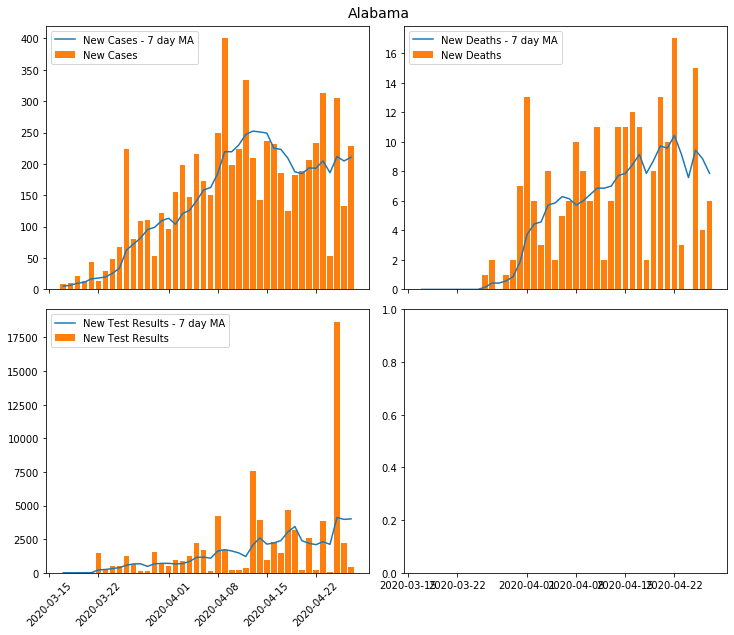

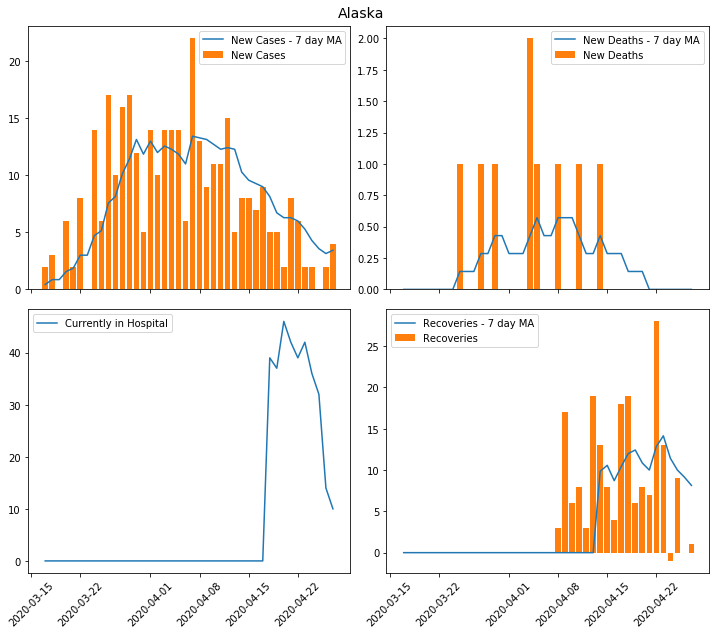

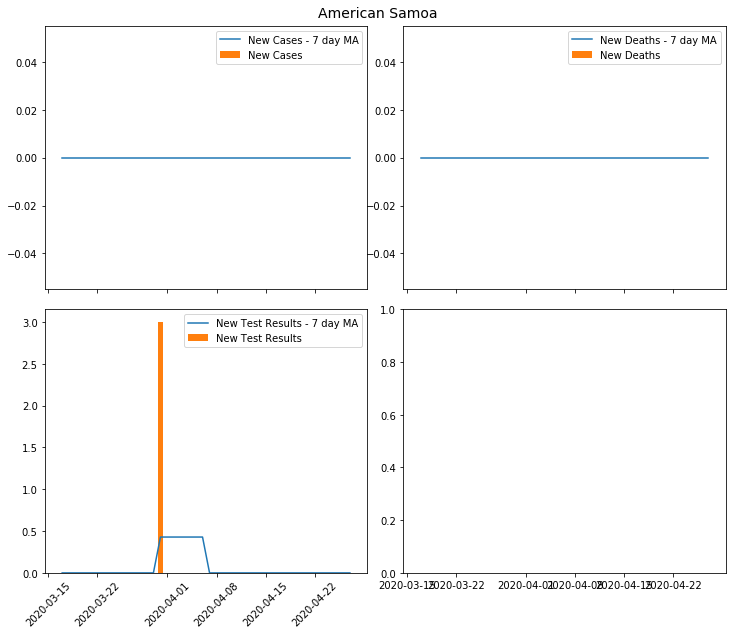

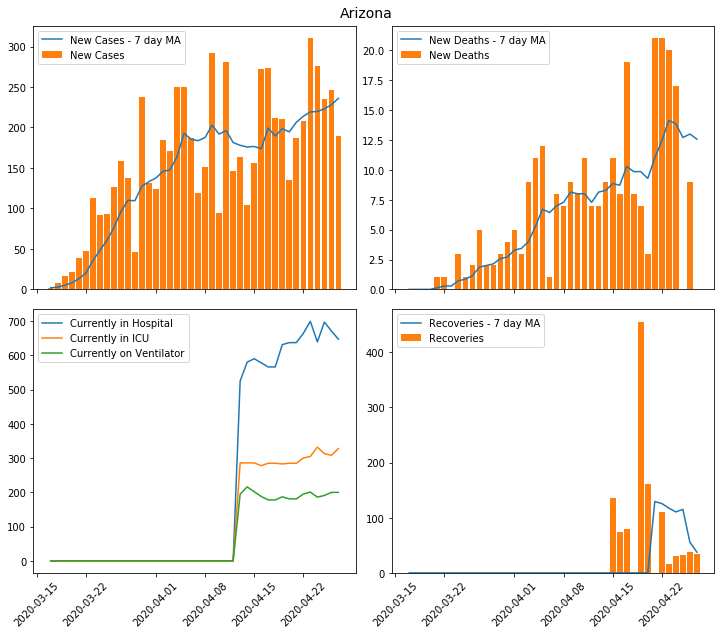

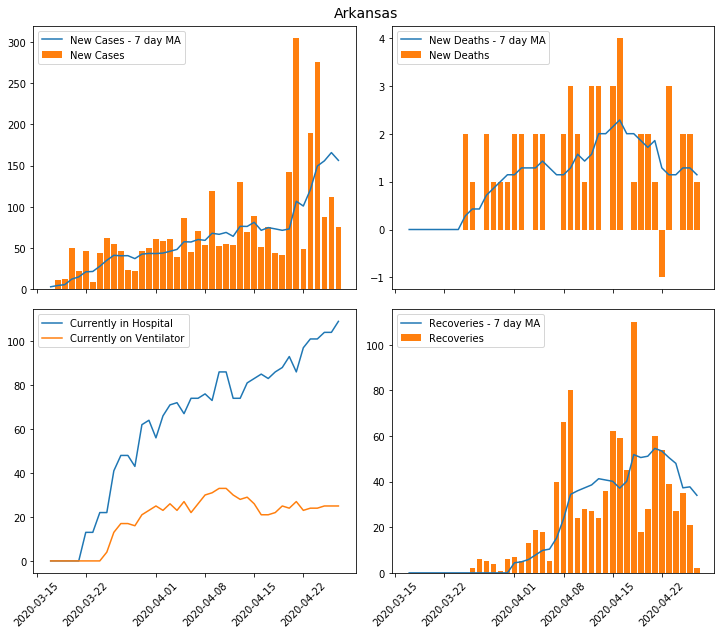

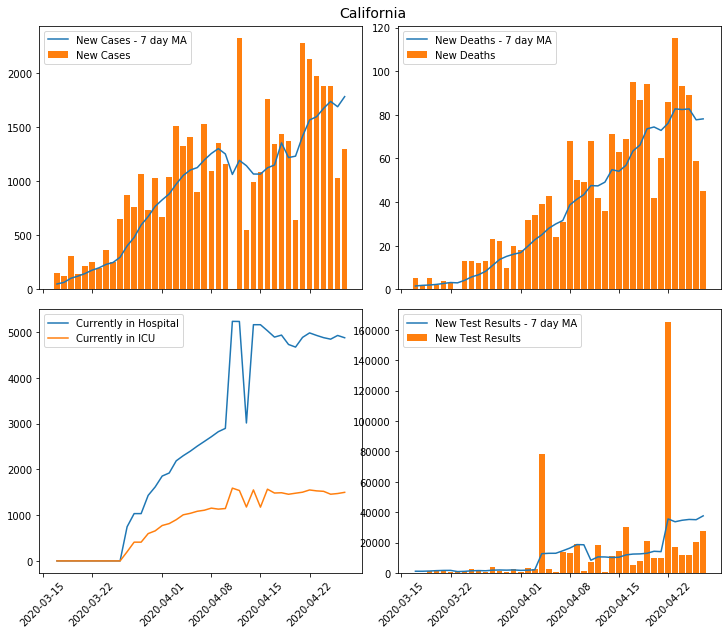

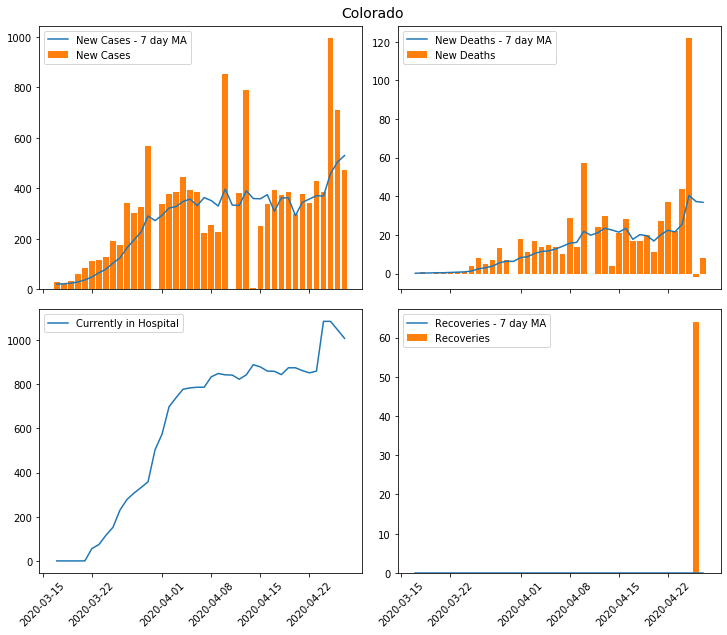

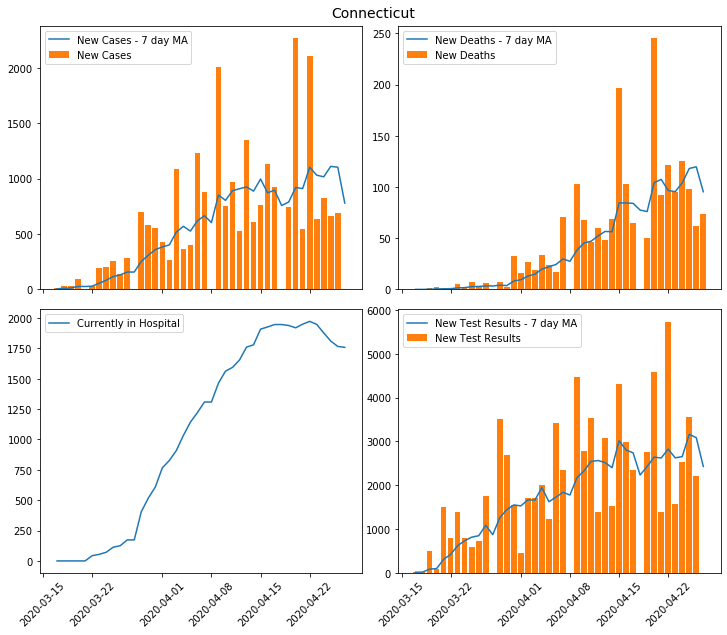

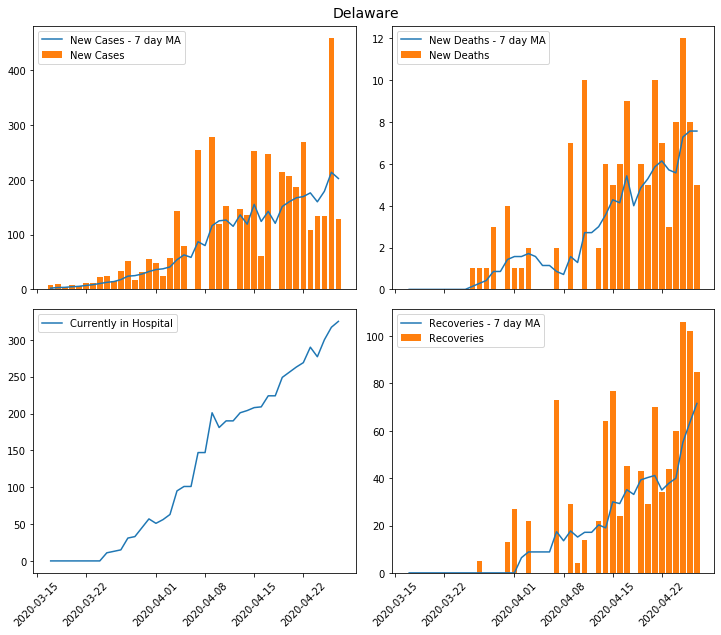

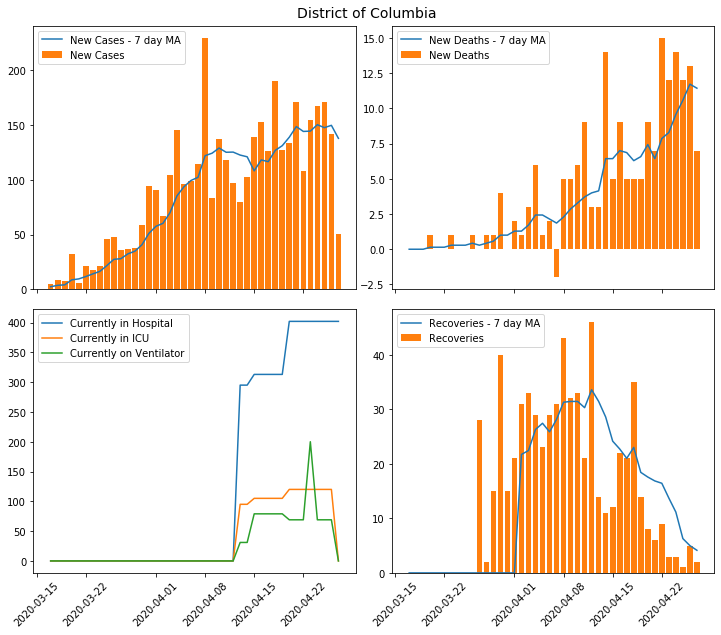

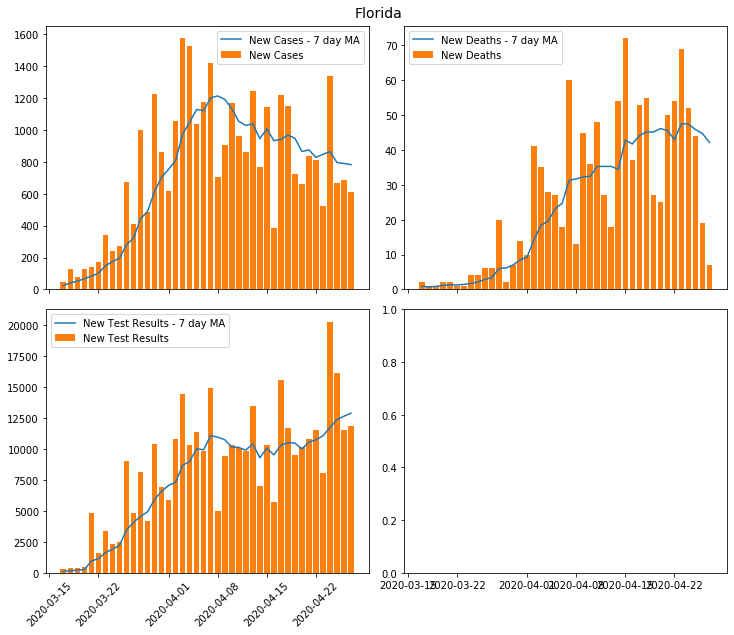

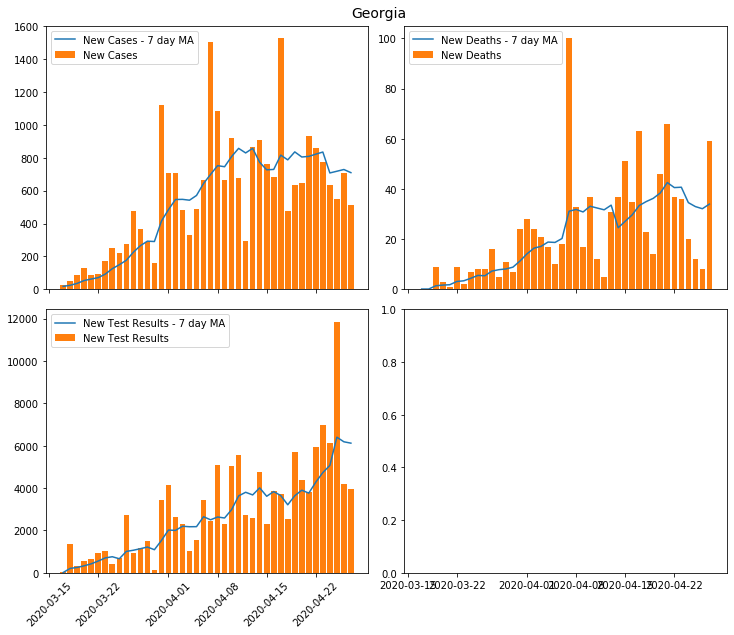

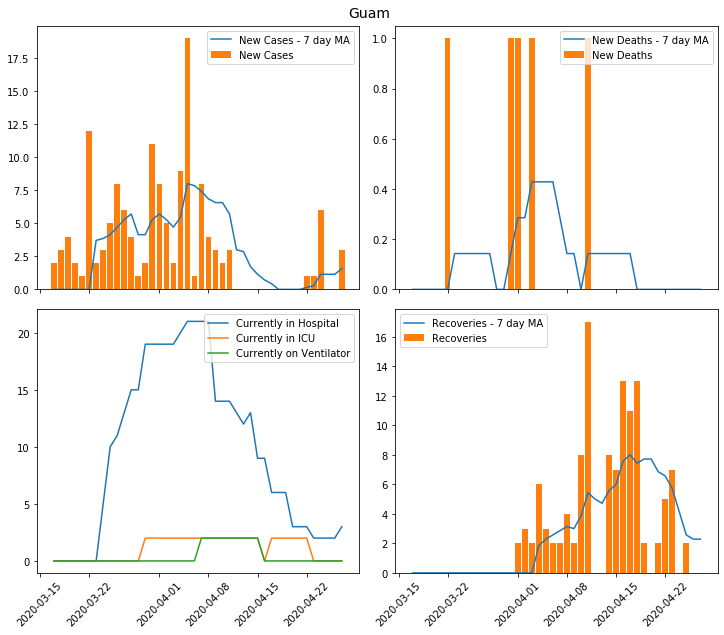

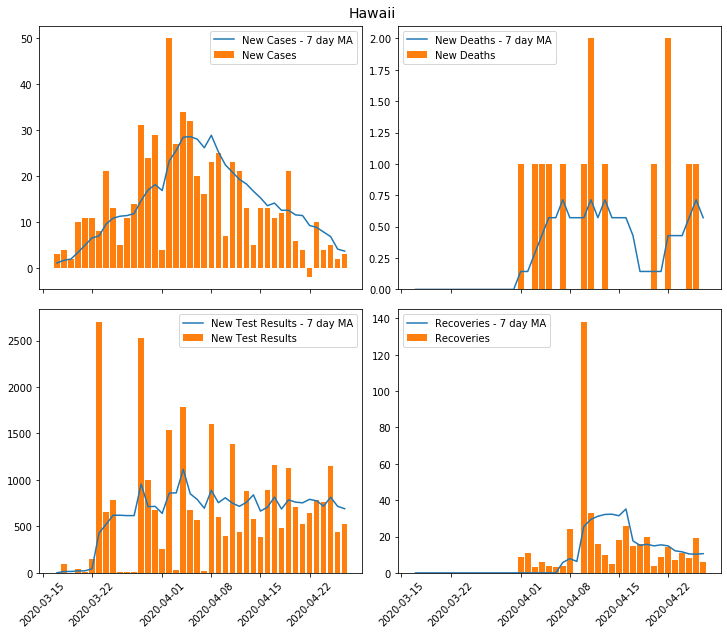

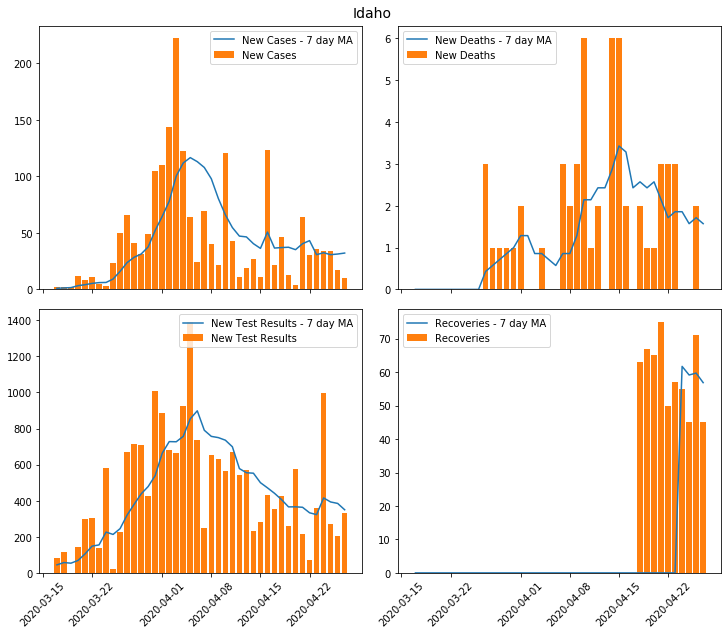

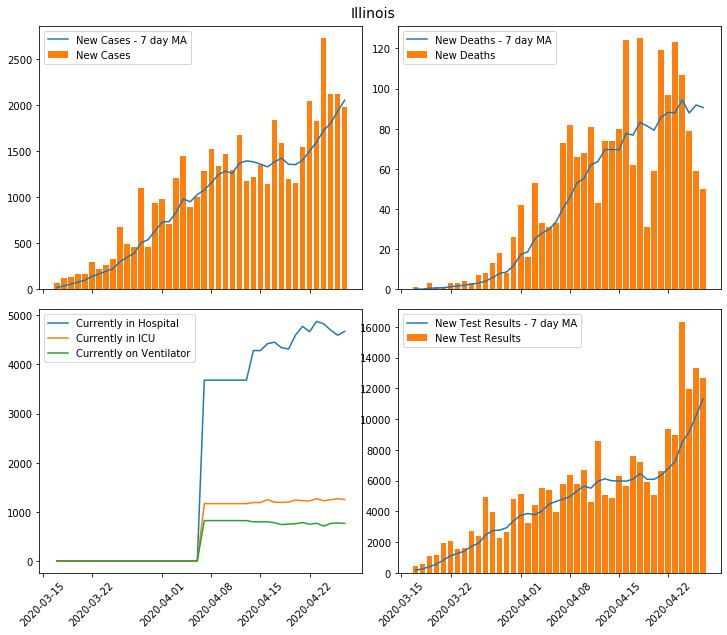

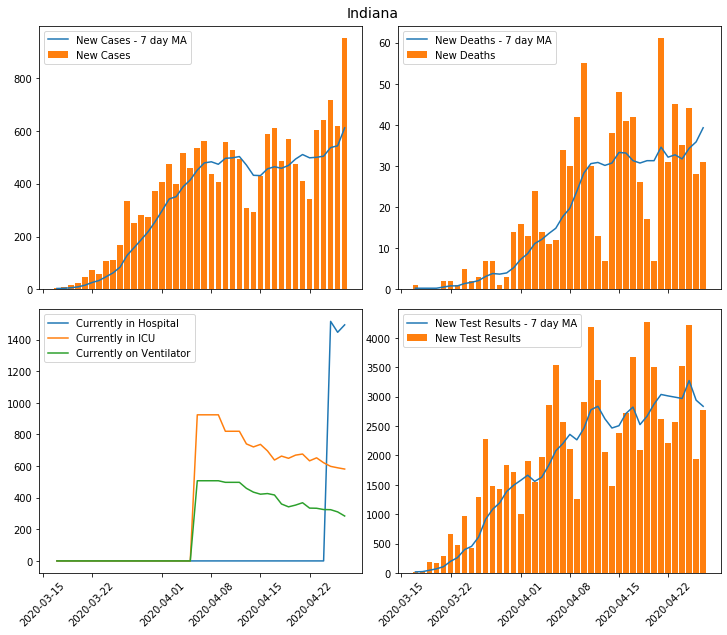

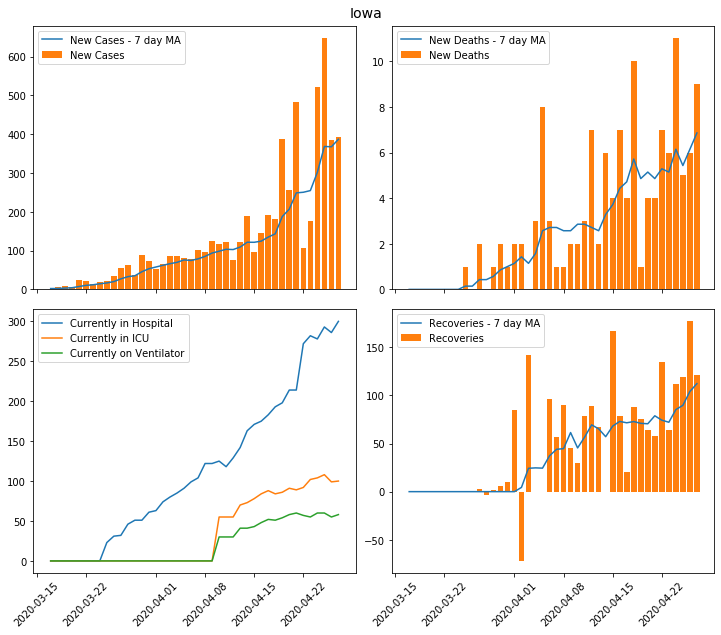

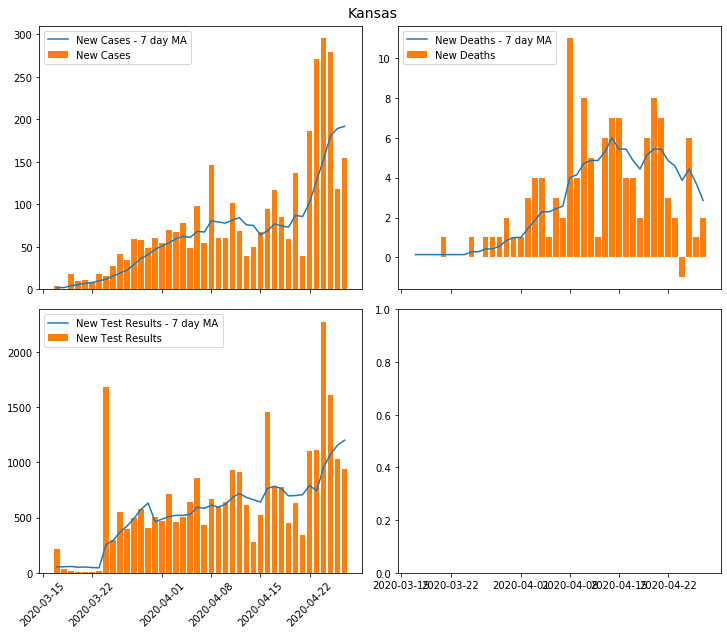

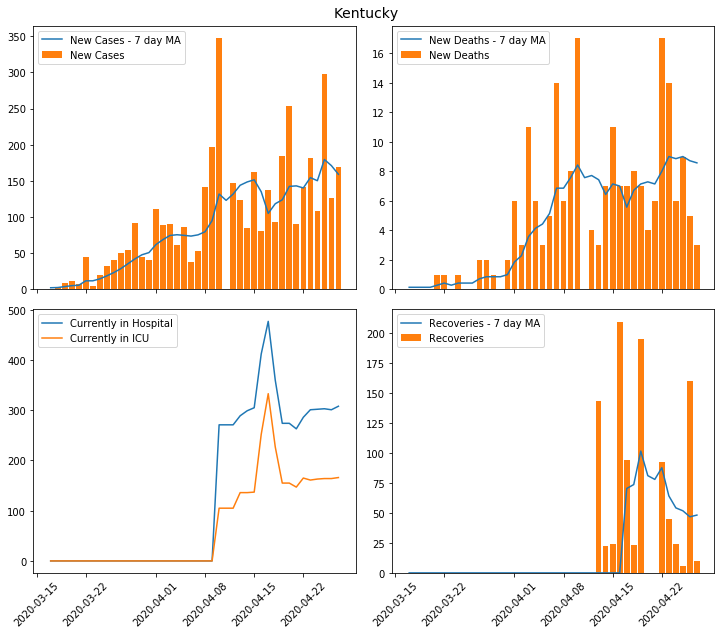

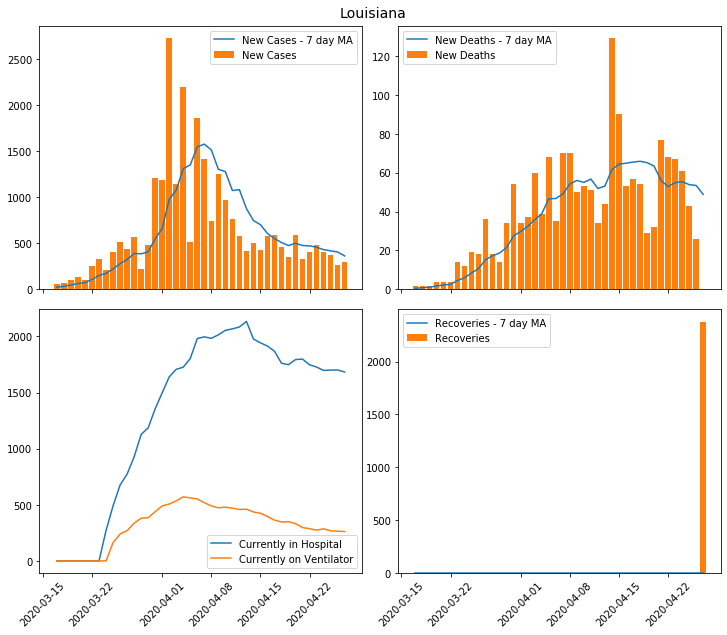

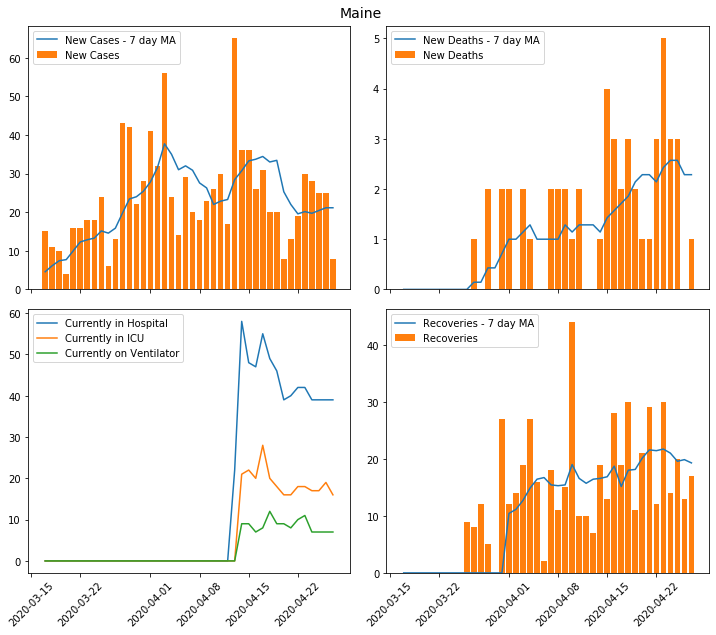

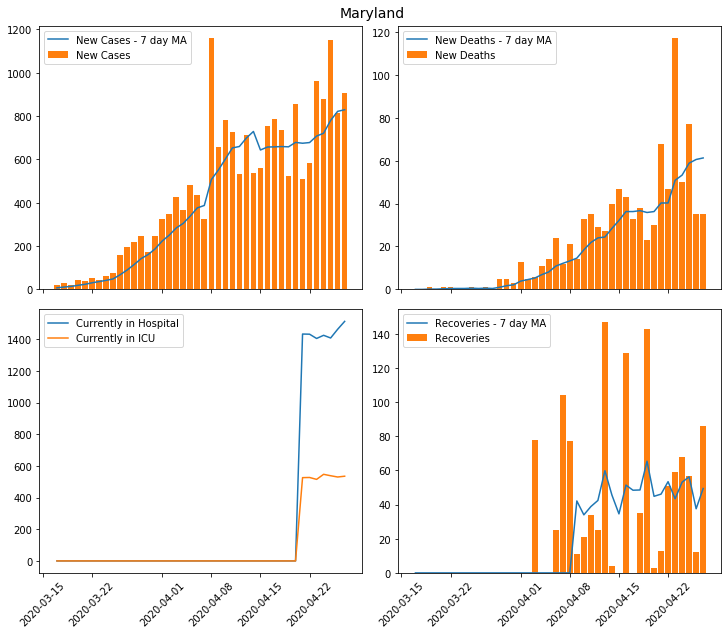

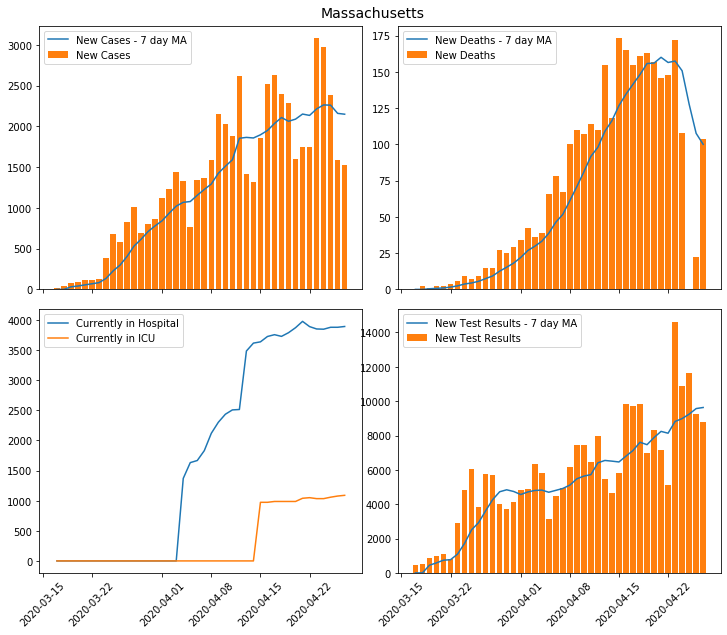

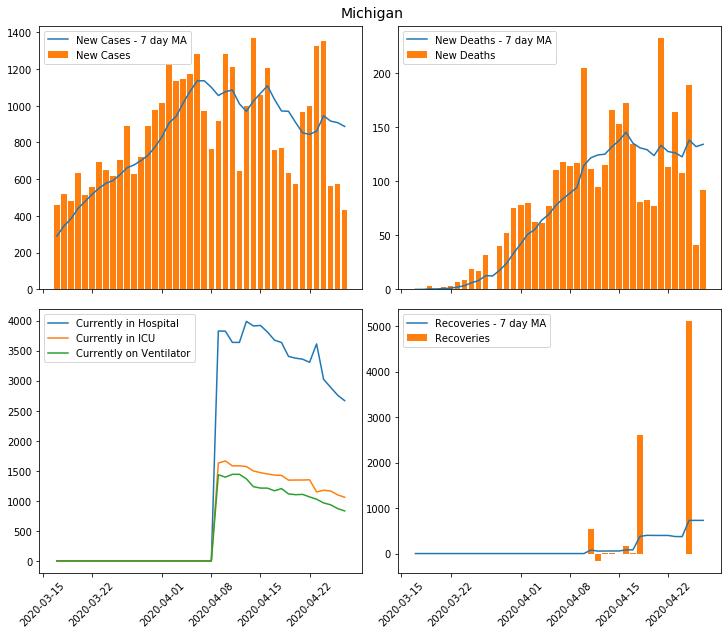

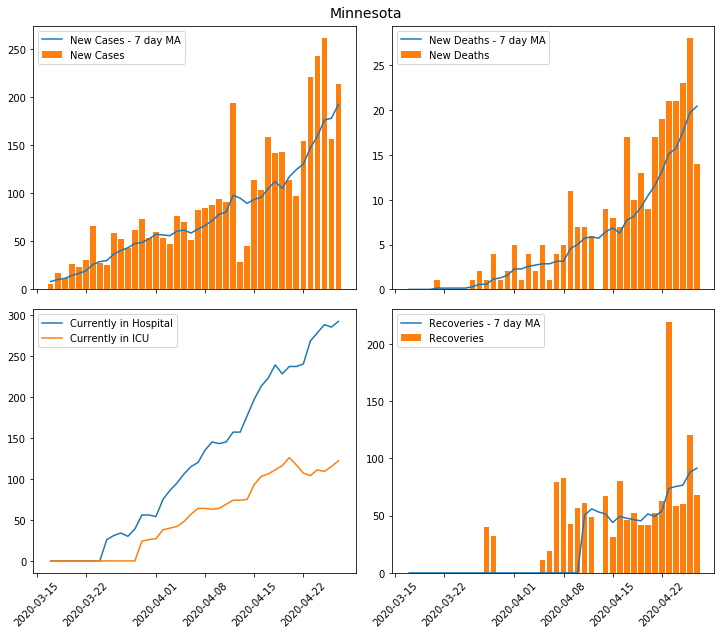

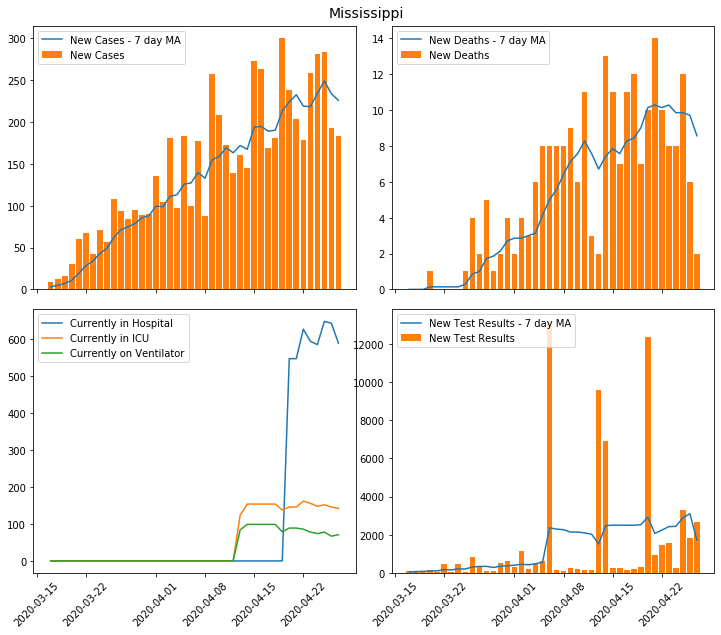

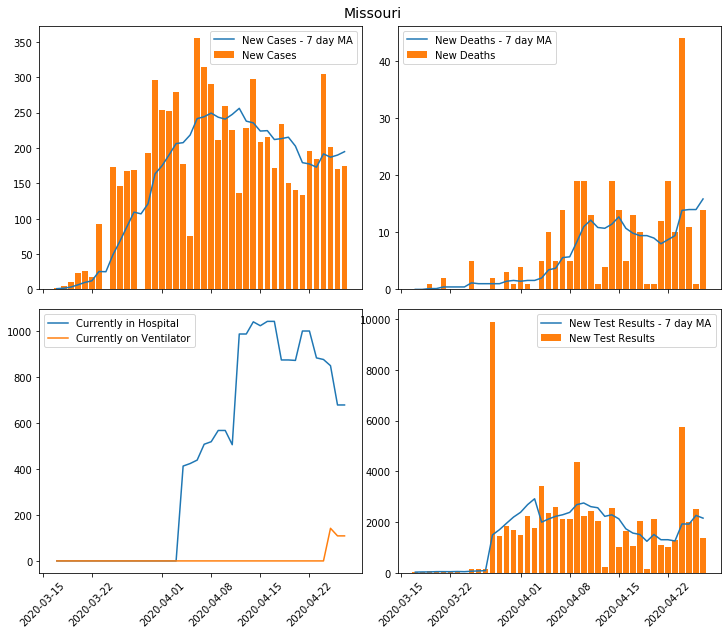

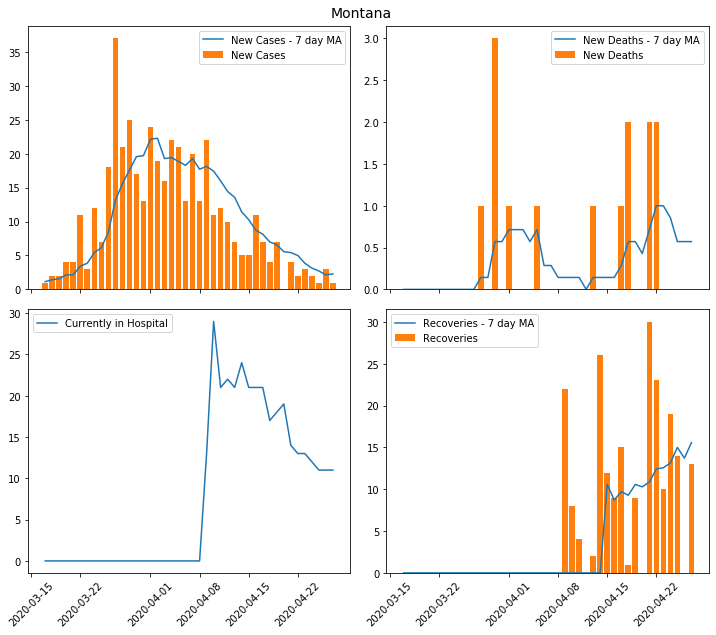

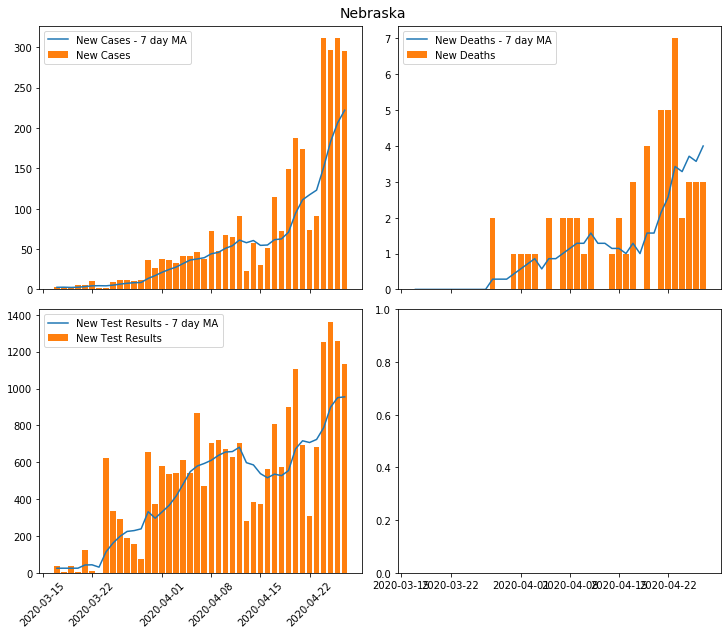

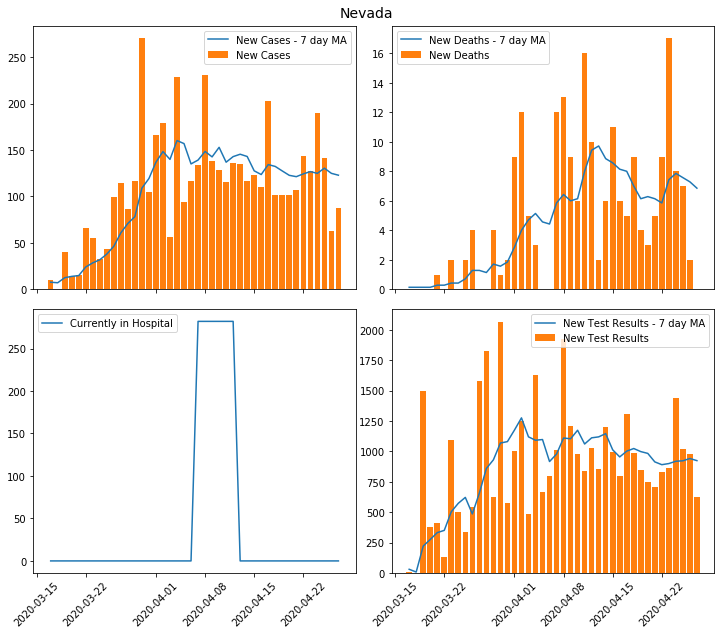

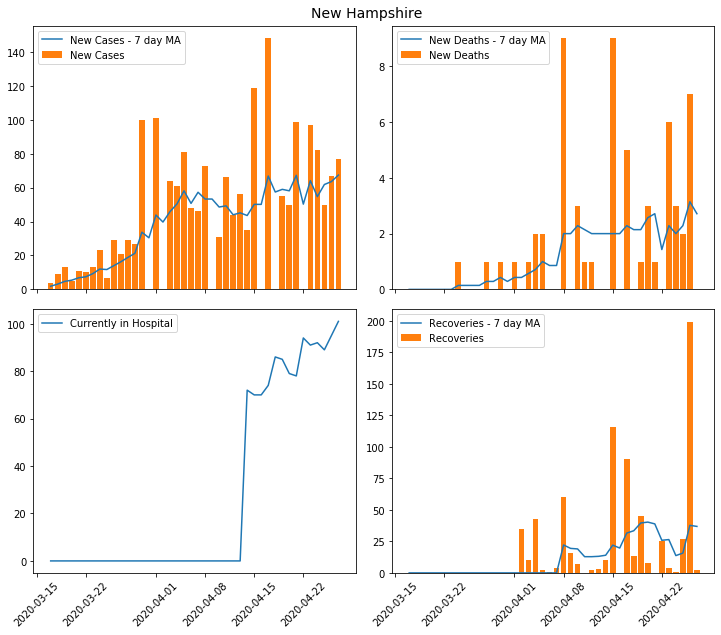

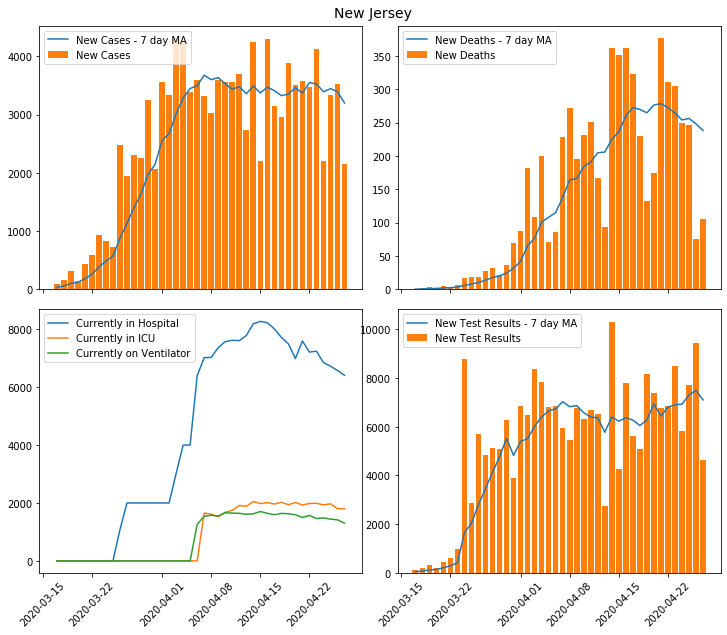

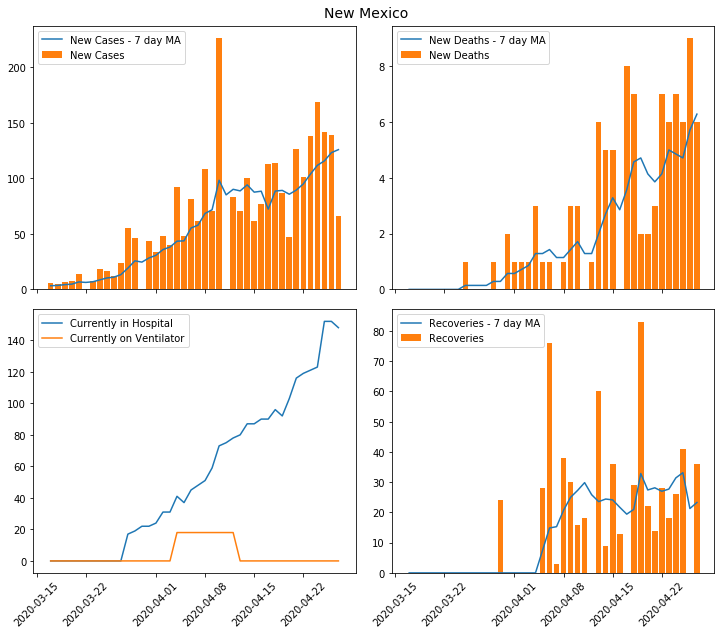

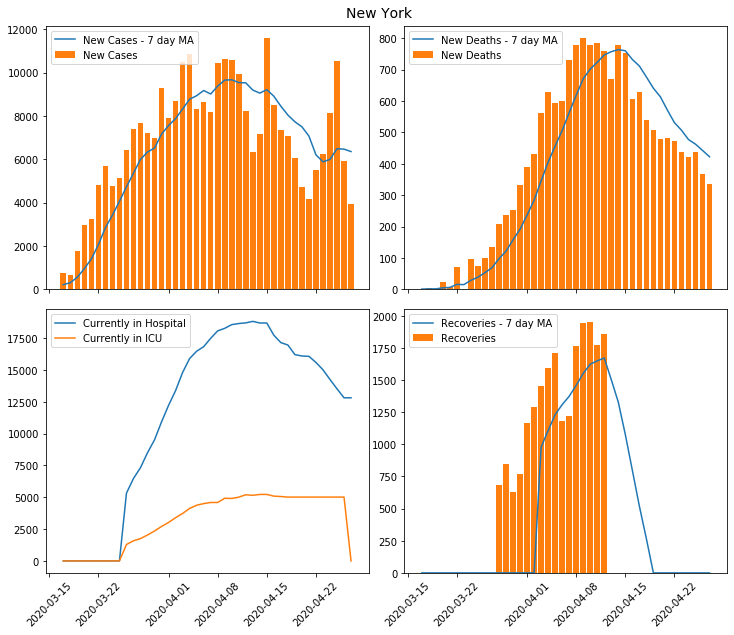

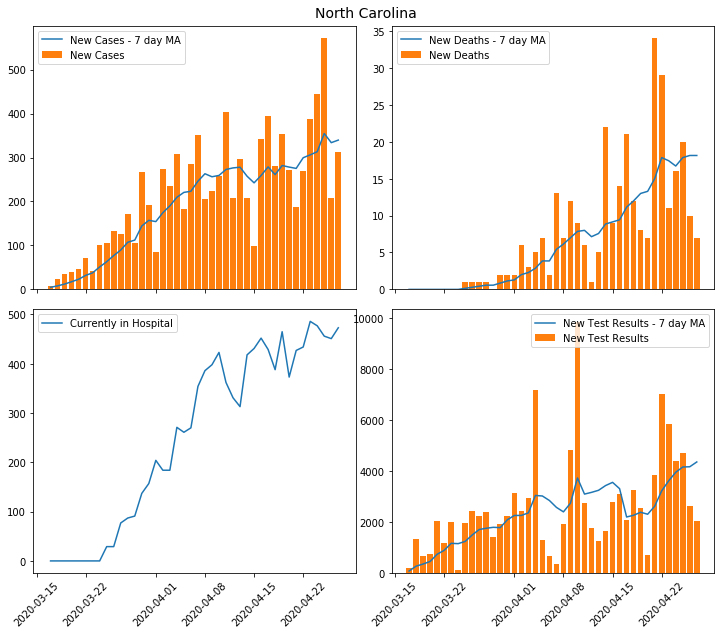

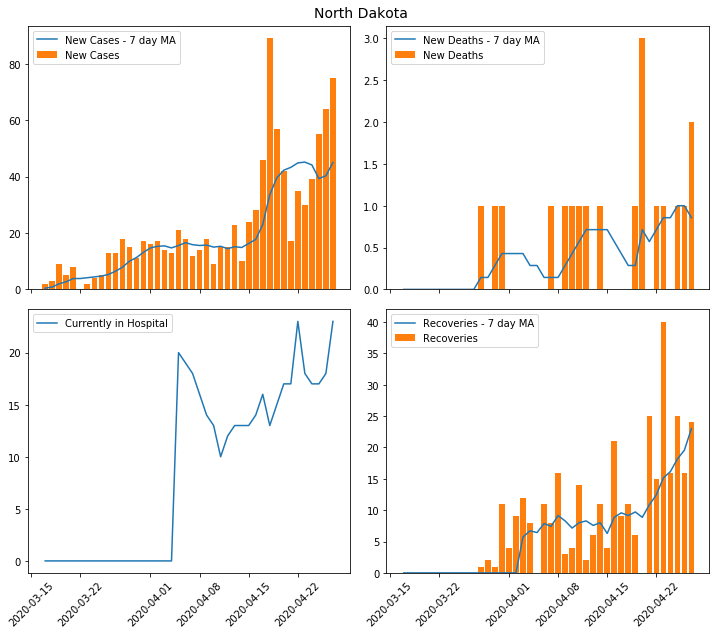

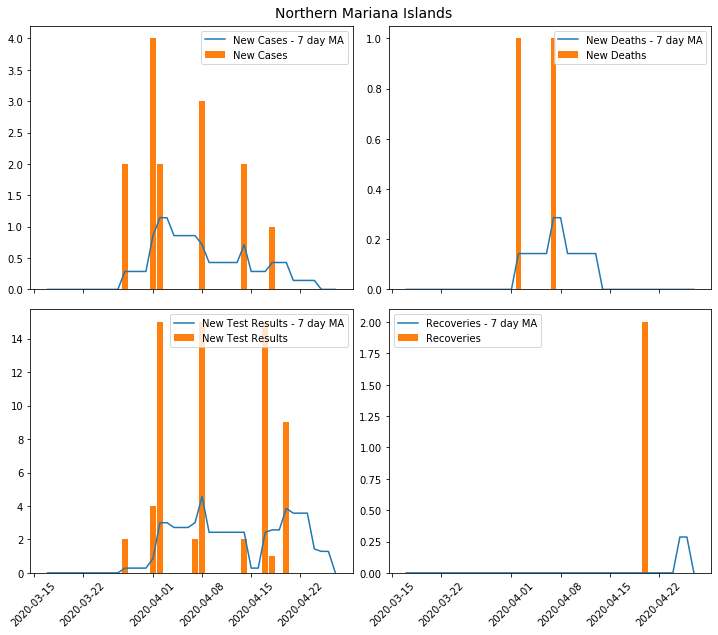

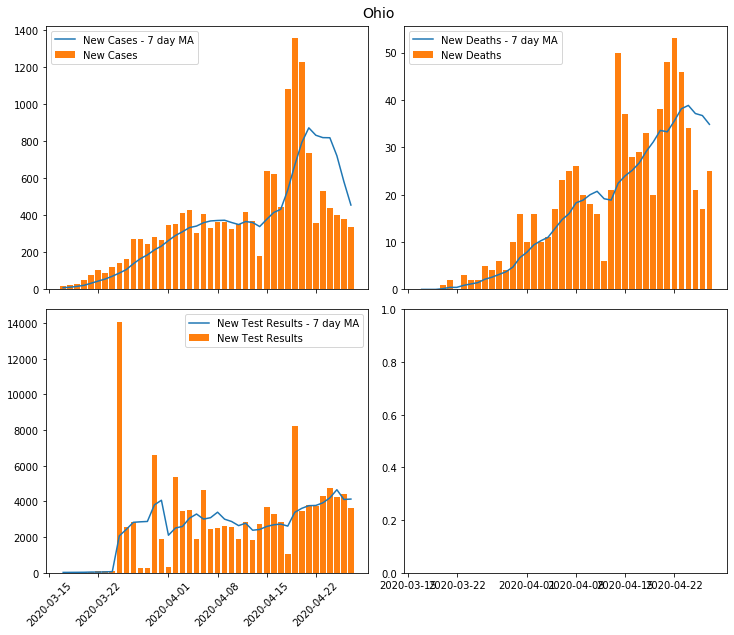

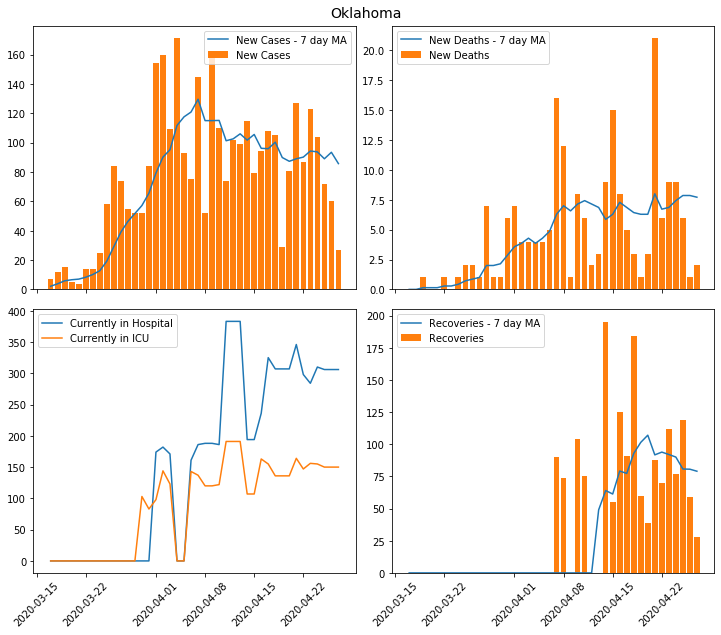

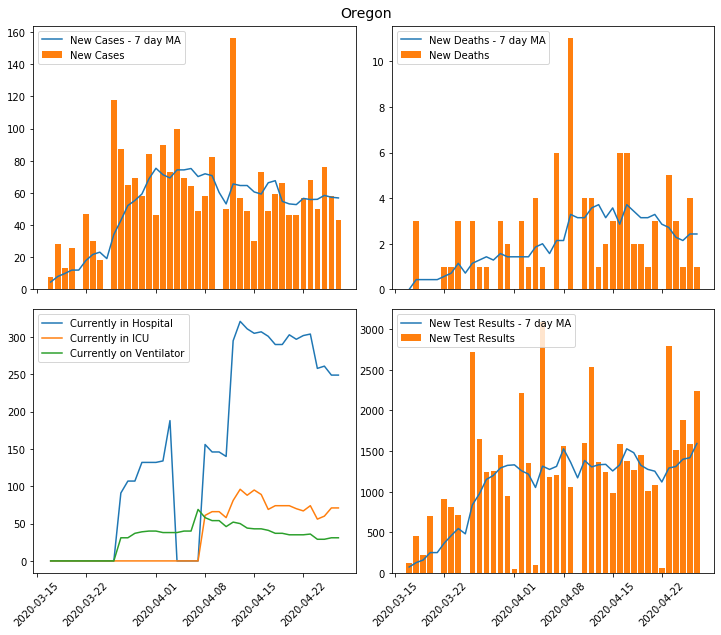

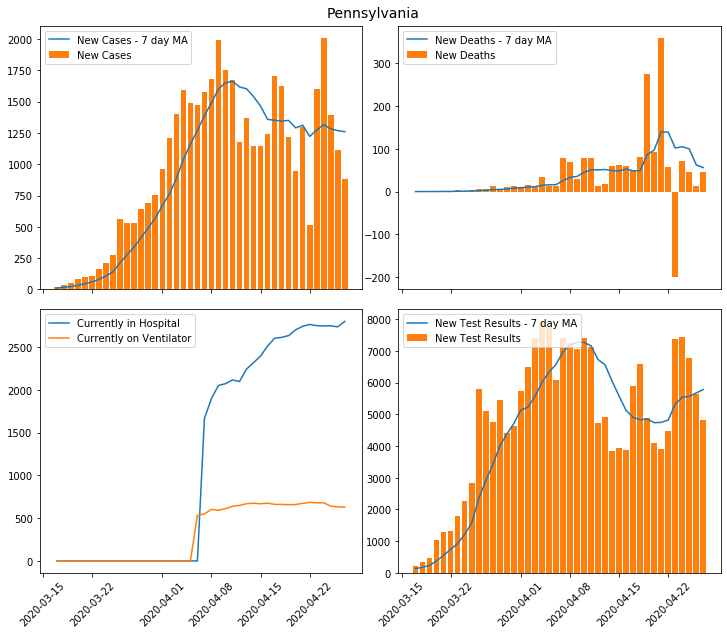

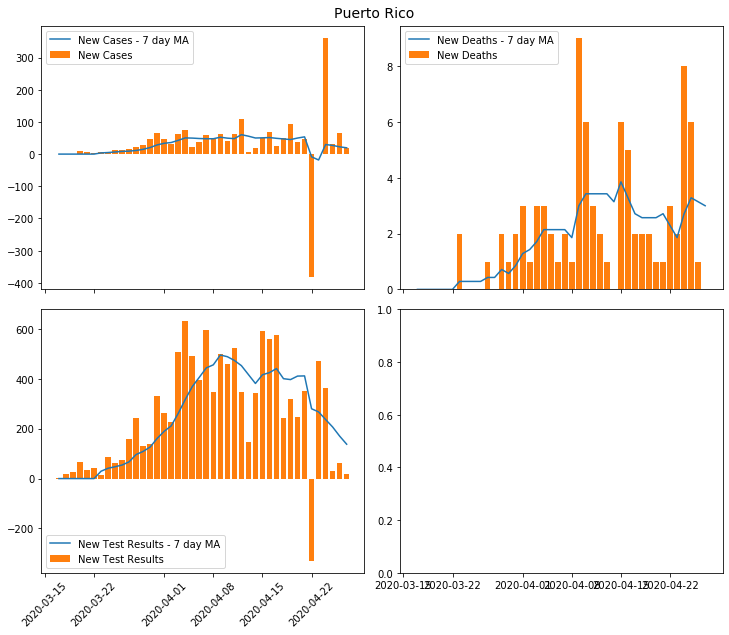

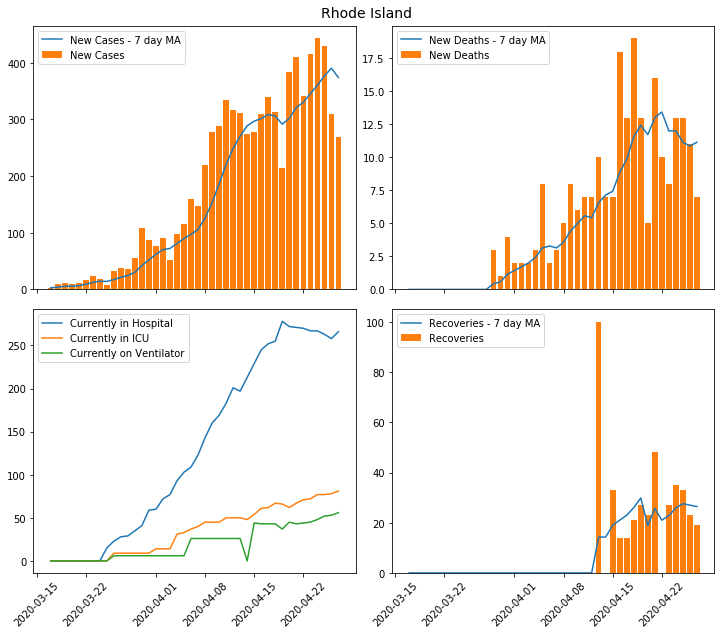

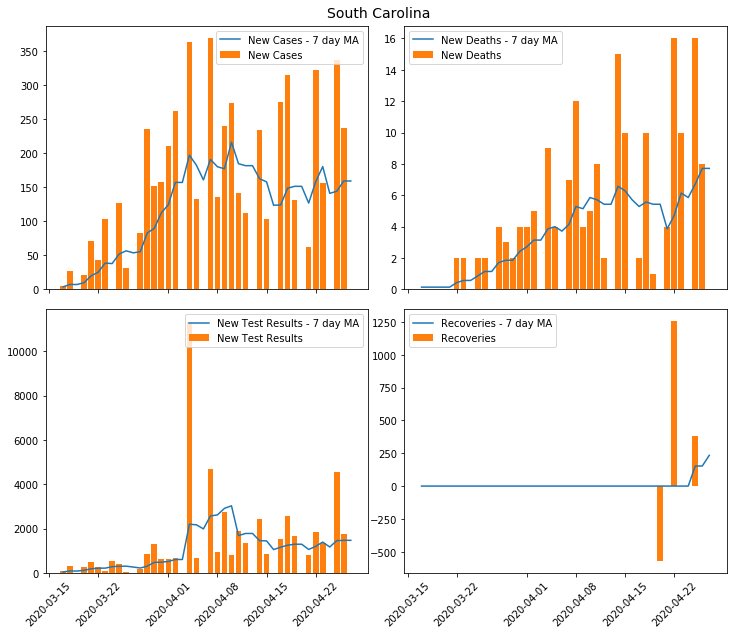

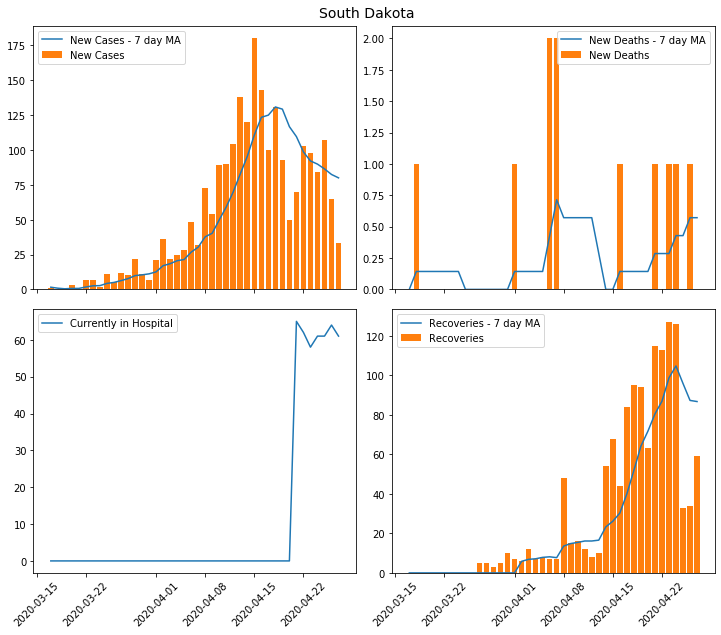

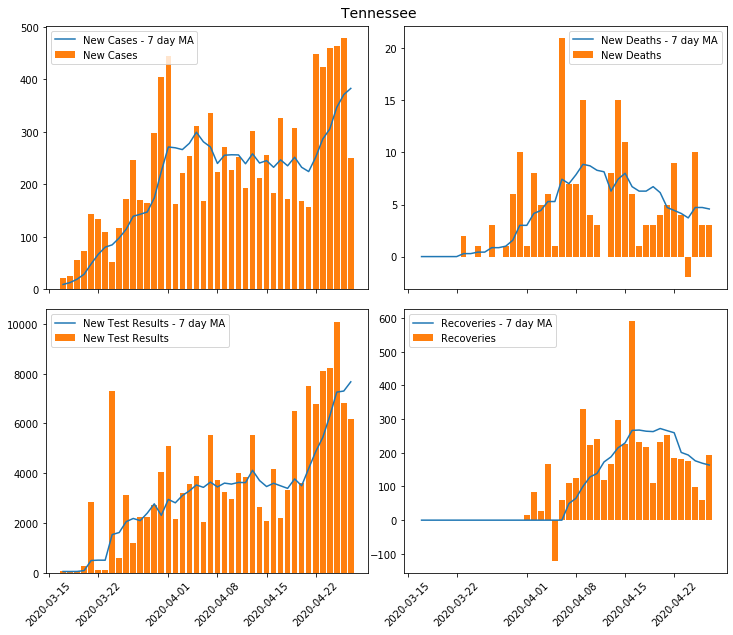

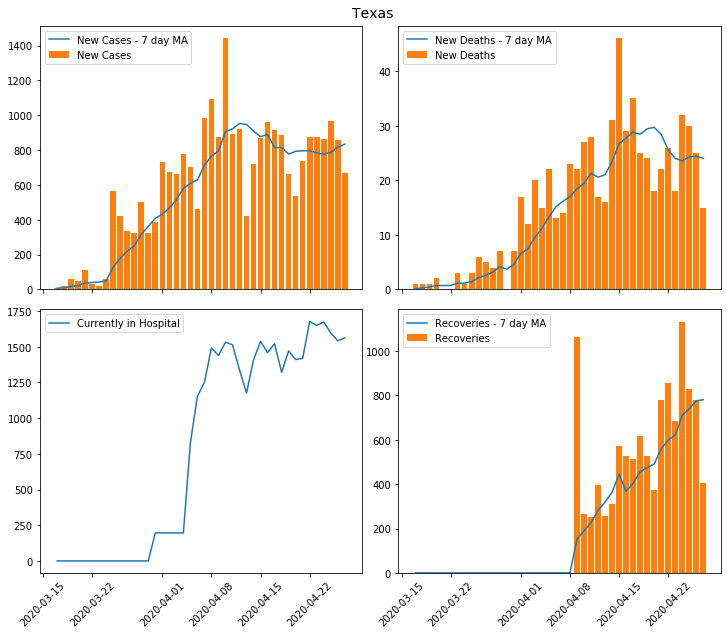

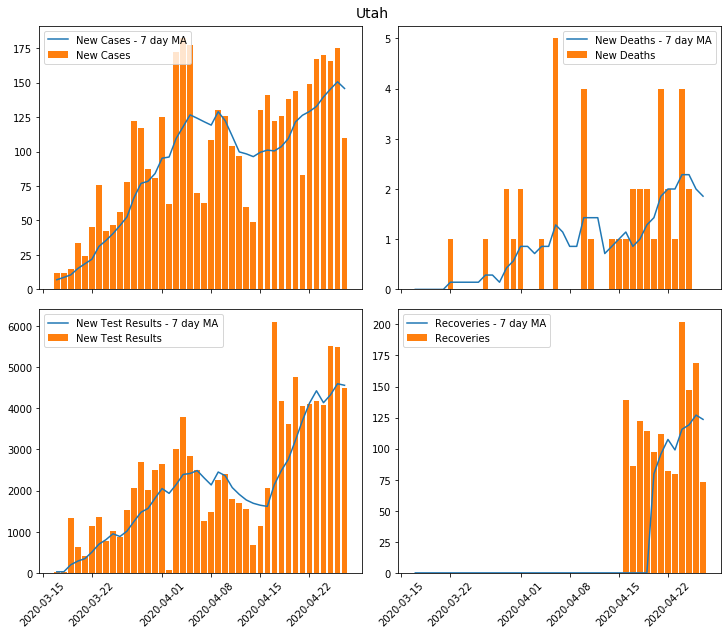

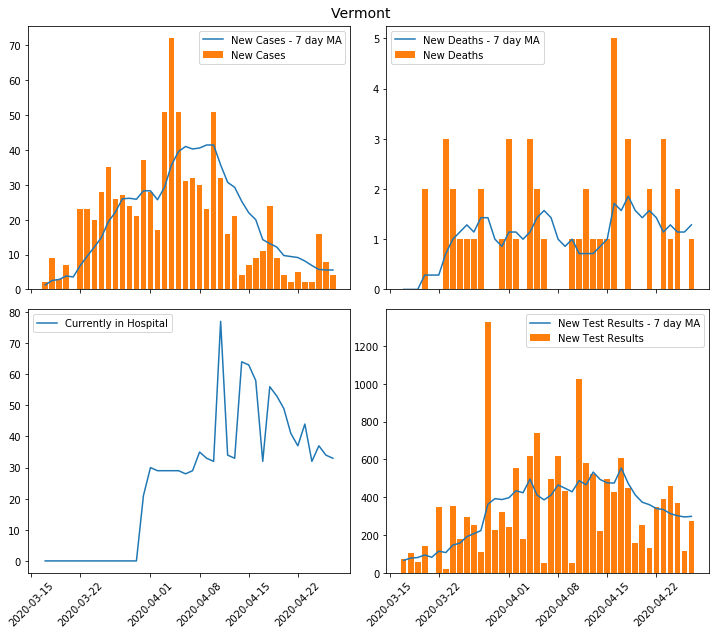

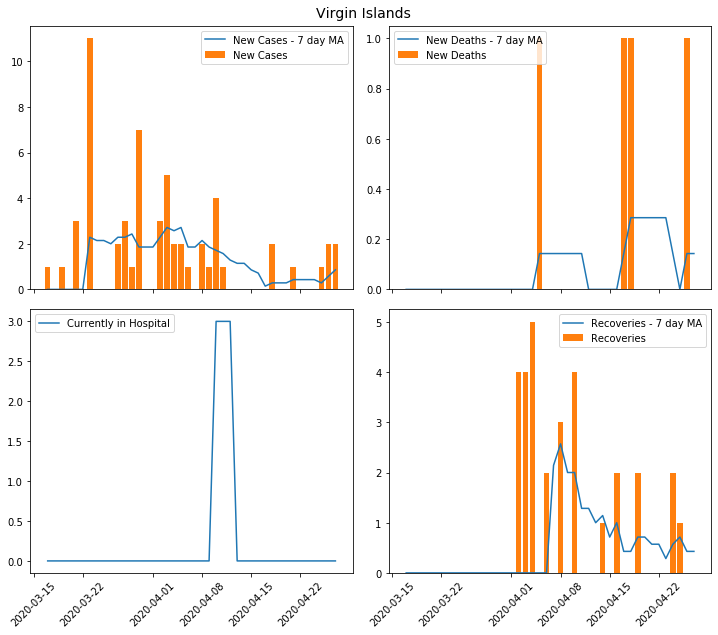

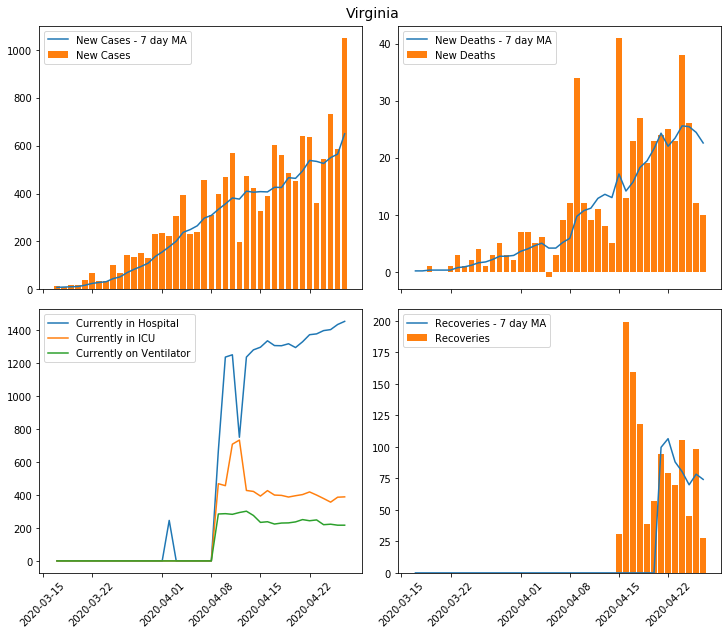

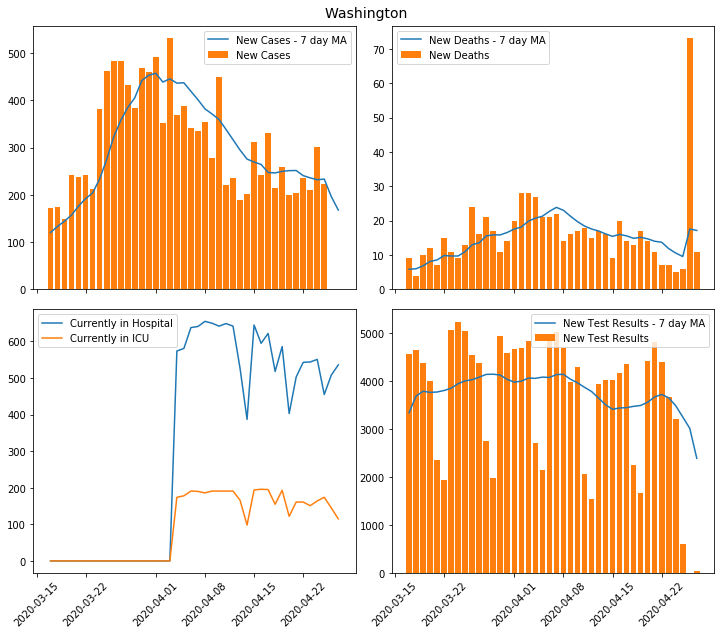

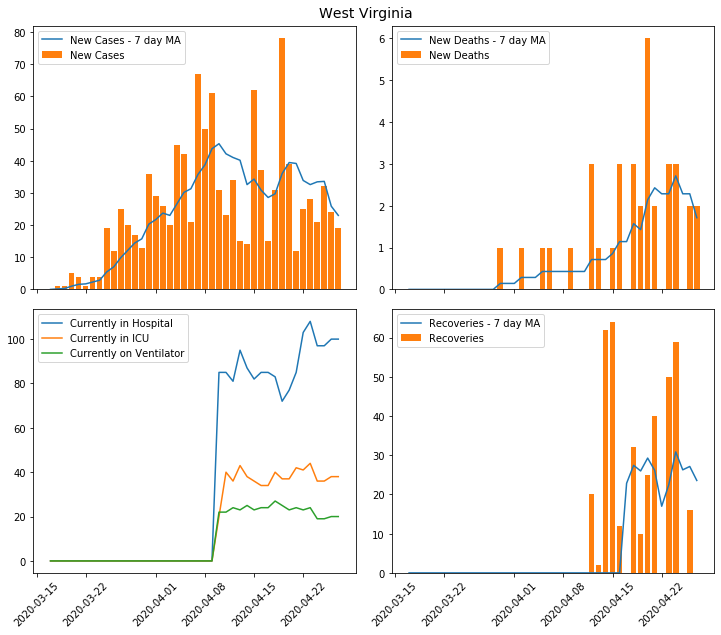

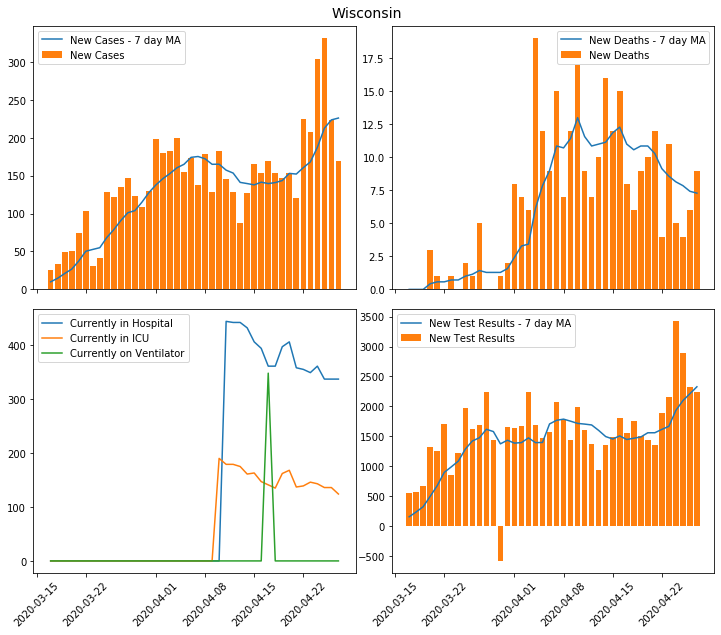

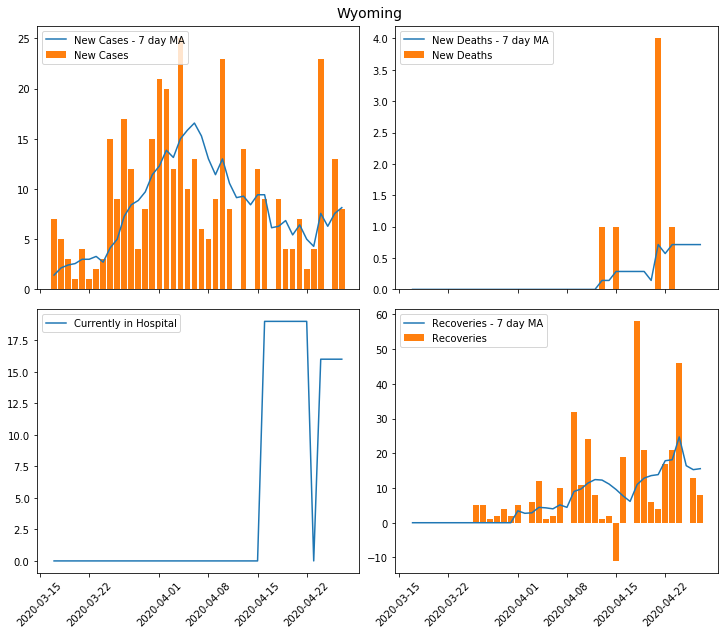

In [24]:
for state in los:
    plot_state(state)